In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from drl_grams import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
%matplotlib widget
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

# Genetic Algorithms

In the directory `genetic_algorithm_results/` the results obtained using genetic algorithms can be found. Different subdirectories represent different combinations of hyperparameters. First, we will study 20 samples obtained using three different fitness functions:

- **reward based**: (reward_based) emulates RL reward from [1], in the sense that it accumulates over time steps rewarding better fidelity and discounting for each extra step with a reward decay gamma to promote faster transmissions
- **natural based**: (loc_based) also accumulates over time steps but rewards a transmission that behaves in a similar way to the natural evolution. The *wave* propagates at a similar speed but tries to achieve a higher max probability.
- **ipr based**: (ipr_based) rewards a localized transition, in the sense that it attempts to have a concentrated package

We also study two action sets:
- **Zhang actions**: Set of actions used in the original work of Zhang et al [1]
- **One Action Per Site**: Set of actions consisting of the N actions corresponding to a control site on each qubit plus the *zero* action which means not controlling any site.

Different subdirectories represent different combinations of hyperparameters. For example, the following 4 subdirectories include results correspoding to the two first described fitness functions for both action sets. 

In [2]:
rb_zhang = 'genetic_algorithm_results/rb_zhang/'   # Reward-based fitness function and Zhang et al actions
rb_oaps = 'genetic_algorithm_results/rb_oaps/'     # Reward-based fitness function and one action per site
lb_zhang = 'genetic_algorithm_results/lb_zhang/'   # Natural-based fitness function and Zhang et al actions
lb_oaps = 'genetic_algorithm_results/lb_oaps/'     # Natural-based fitness function and one action per site

directories = [rb_zhang, rb_oaps, lb_zhang, lb_oaps]

A summary of all the hyper-parameters and system parameters used to obtain each directory can be accesed by calling the `access_ga_params` function. For example, the output of the following cell shows the parameters corresponding to the directory `rb_zhang`, where we employ reward-based fitness and Zhang et al actions, which can be verified in the printed dataframe. 

In [3]:
rb_zhang_parameters = access_ga_params(rb_zhang,print_params=True)

Showing parameters for genetic_algorithm_results/rb_zhang/:
╒═══════════════════╤═══════════════════════╤══════════════╕
│ Section           │ Parameter             │ Value        │
╞═══════════════════╪═══════════════════════╪══════════════╡
│ system_parameters │ initial_n             │ 8            │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ final_n               │ 64           │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ n_step                │ 4            │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ dt                    │ 0.15         │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ b                     │ 100          │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ speed_fraction        │ 1.1          │
├───────────────────┼───────────────────────┼──────────────┤
│ ga_initialization │ num

We can also access a particular parameter value using `get_parameter_value`

In [4]:
for directory in directories:
    print('--------------------------------------------------')
    print('Directory: ', directory)
    print('--------------------------------------------------')
    ga_params = access_ga_params(directory,print_params=False)
    used_fitness = get_parameter_value(ga_params,'fitness_function',print_value=True)
    used_actions = get_parameter_value(ga_params,'action_set',print_value=True)


--------------------------------------------------
Directory:  genetic_algorithm_results/rb_zhang/
--------------------------------------------------
Parameter 'fitness_function' :  reward_based
Parameter 'action_set' :  zhang
--------------------------------------------------
Directory:  genetic_algorithm_results/rb_oaps/
--------------------------------------------------
Parameter 'fitness_function' :  reward_based
Parameter 'action_set' :  oaps
--------------------------------------------------
Directory:  genetic_algorithm_results/lb_zhang/
--------------------------------------------------
Parameter 'fitness_function' :  loc_based
Parameter 'action_set' :  zhang
--------------------------------------------------
Directory:  genetic_algorithm_results/lb_oaps/
--------------------------------------------------
Parameter 'fitness_function' :  loc_based
Parameter 'action_set' :  oaps


In [5]:
get_different_parameters(directories,print_params=True)


Parameters with Different Values:
╒══════════════════╤══════════════════════════════════════╤═══════════════════════════════════════╤══════════════════════════════════════╤═══════════════════════════════════════╕
│ Parameter        │ genetic_algorithm_results/lb_oaps/   │ genetic_algorithm_results/lb_zhang/   │ genetic_algorithm_results/rb_oaps/   │ genetic_algorithm_results/rb_zhang/   │
╞══════════════════╪══════════════════════════════════════╪═══════════════════════════════════════╪══════════════════════════════════════╪═══════════════════════════════════════╡
│ action_set       │ oaps                                 │ zhang                                 │ oaps                                 │ zhang                                 │
├──────────────────┼──────────────────────────────────────┼───────────────────────────────────────┼──────────────────────────────────────┼───────────────────────────────────────┤
│ directory        │ lb_oaps                              │ lb_zhang  

Directory,genetic_algorithm_results/lb_oaps/,genetic_algorithm_results/lb_zhang/,genetic_algorithm_results/rb_oaps/,genetic_algorithm_results/rb_zhang/
Parameter,,,,
action_set,oaps,zhang,oaps,zhang
directory,lb_oaps,lb_zhang,rb_oaps,rb_zhang
fitness_function,loc_based,loc_based,reward_based,reward_based


We can analyze the obtained results for different combinations of fitness functions and rewards. The results file contains the following metrics: 

- `max_fidelity`: max. transmission probability
- `ttime`: time step for which the maximum transmission probability is achieved
- `cpu_time`: cpu time spent for that sample
- `generations` : number of genetic algorithm generations


The `plot_metric` function shows the mean and max value of the different metrics across the 20 samples (or, in general, all the samples in the provided directory). It takes as arguments the directories to analyze and the corresponding metric. 

### Mean and max fidelity

['lb_oaps', 'lb_zhang', 'rb_oaps', 'rb_zhang']


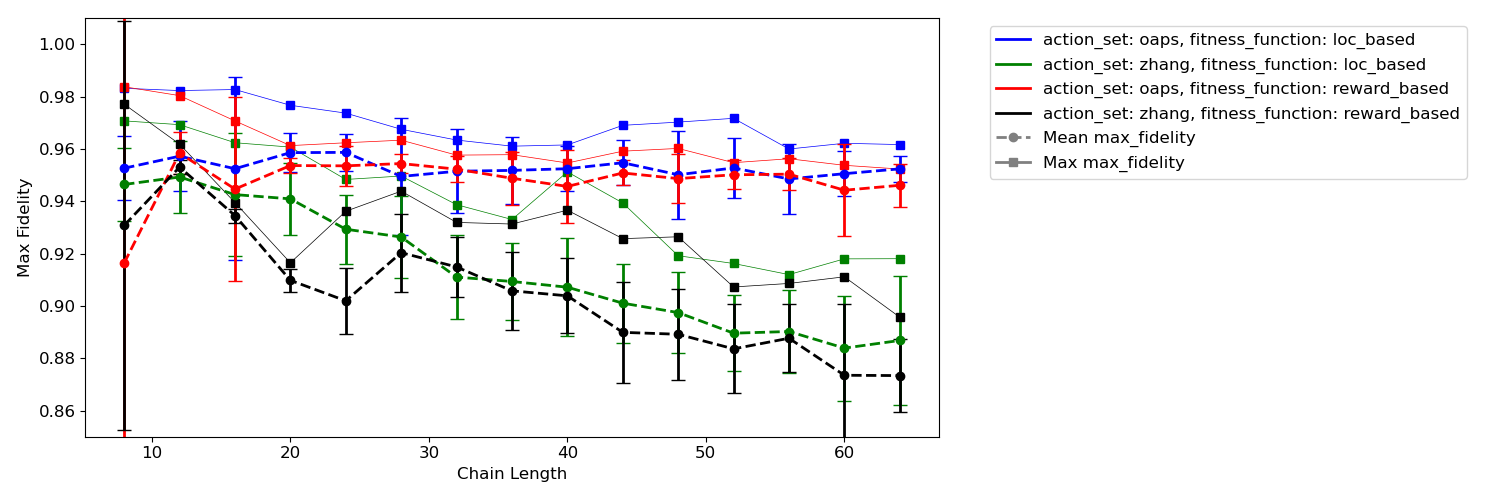

In [6]:
plt.figure(figsize=(15, 5))
plot_metric(directories,'max_fidelity')
plt.ylabel('Max Fidelity')
plt.xlabel('Chain Length')
plt.ylim(0.85,1.01)
plt.tight_layout()

As one would expect, the first set of actions performs poorly for longer chains since it has less control sites. We are currently studying the minimum number of control sites required to achieve an acceptable transmission. 

### CPU time

['lb_oaps', 'lb_zhang', 'rb_oaps', 'rb_zhang']


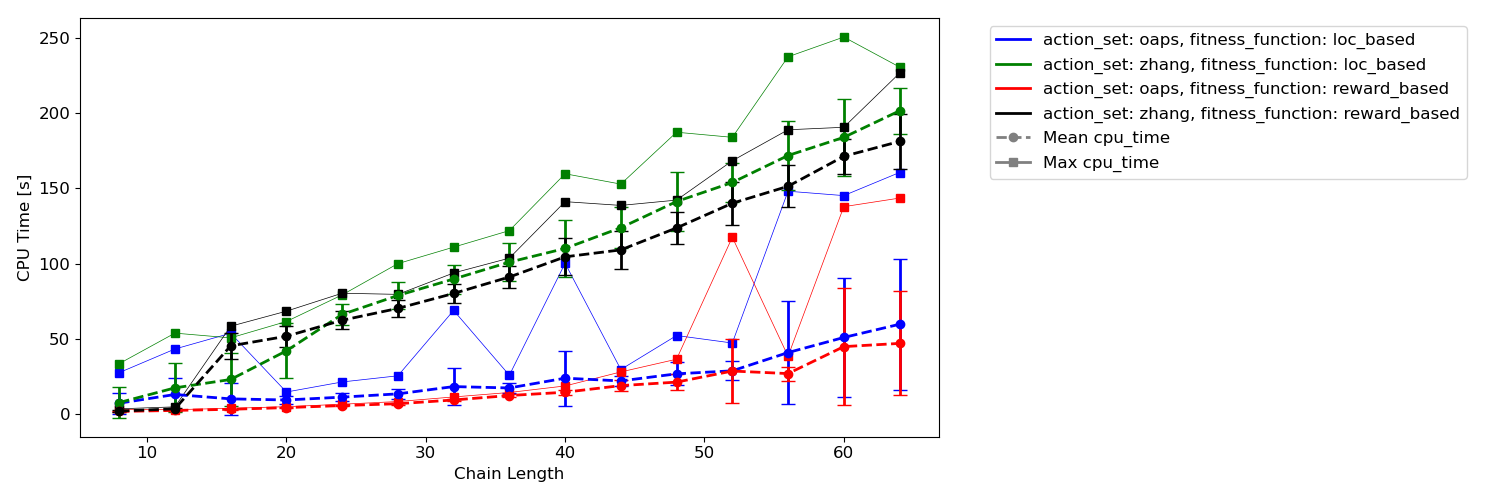

In [7]:
plt.figure(figsize=(15, 5))
plot_metric(directories,'cpu_time')
plt.xlabel('Chain Length')
plt.ylabel('CPU Time [s]')
plt.tight_layout()

Even for long chains, the algorithm is really efficient. The longer times in worse performance scenarios have to do with the fact that if the algorithm does not converge it takes a longer total time since it performs more generations trying to find a better solution.

# Effect in the solution of different fitness functions

To study the effect of different fitness functions we can also study the behaviour of the transition probability over time.

FileNotFoundError: [Errno 2] No such file or directory: 'lb_oapsn8/'

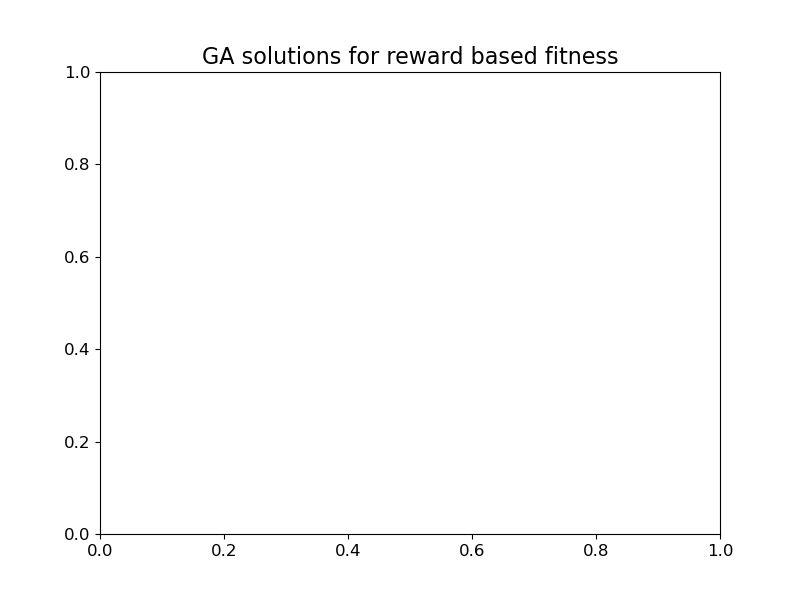

In [8]:
plt.figure(figsize=(8, 6))
fs=16
plt.title('GA solutions for reward based fitness', fontsize=fs)
n=8
plot_ga_solutions([lb_oaps,rb_oaps],n,['original','original'],add_natural=True,fs=16)
